# **Data analysis**

# **Environment Setup**

In [65]:
import numpy as np
import random as rm
import seaborn as sns
from tqdm import trange
import time
import sq_fast

from numba import njit

import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

import math
import pandas as pd
from pathlib import Path

import os
from scipy.spatial import cKDTree
from scipy.signal import find_peaks
import plotly.express as px
import numpy as np

import kaleido

In [66]:
plt.style.use('science.mplstyle')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral"
})

plt.rcParams.update({'font.size': 14, 'legend.fontsize': 12,})


In [67]:
# plt.rcParams['figure.figsize'] = (6, 4)
# plt.rcParams['figure.dpi'] = 100
# sns.set_style("ticks")
# sns.set_theme(
#     style="white",
#     context="notebook",
#     font_scale=1.2,
#     rc={
#         "font.family": "serif",
#         "font.serif": ["Times New Roman", "DejaVu Serif"],
#         "font.size": 16,
#         "axes.labelsize": 16,
#         "axes.titlesize": 16,
#         "xtick.labelsize": 16,
#         "ytick.labelsize": 16,
#         "legend.fontsize": 16,
#         "mathtext.fontset": "cm",
#         "xtick.bottom": True,
#         "ytick.left": True,
#         "axes.titleweight": "bold",
#         "legend.frameon": False,
#         "legend.framealpha": 1,
#         "legend.facecolor": "white",
#         "legend.edgecolor": "black",
#         "lines.linewidth": 1.75,
#         "axes.linewidth": 1.2,
#         "grid.linewidth": 0.6,
#         "grid.alpha": 0.8,
#         "grid.linestyle": "--",
#         "lines.markersize": 5,
#     }
# )
# sns.set_palette("bright")
# plt.rcParams.update({
#     "xtick.direction": "in",
#     "ytick.direction": "in",
#     "xtick.top": True,
#     "ytick.right": True,
#     "xtick.minor.visible": True,
#     "ytick.minor.visible": True,
# })

# **Analysis**

## **Simulation parameters**

In [68]:
from pathlib import Path

simulation_path = Path("./output/n216_density1.00_t1.0-0.0001-0.98/")

def get_simulation_parameters(filepath):
    params = {}
    keys = [
        #"melting", "path", 
        #"N", "freeze_mc_steps", "alpha", "C0", "density",
        "N", "freeze_mc_steps", "alpha", "density",
        "charge", "initial_temp", "final_temp", "temp_step"
    ]
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            if i < len(keys):
                value = line.split('!')[0].strip()
                # Handle types properly
                if keys[i] == "melting" or keys[i] == "N":
                    params[keys[i]] = int(value)
                elif keys[i] == "path":
                    # Remove quotes if present
                    params[keys[i]] = value.strip('"').strip("'")
                else:
                    params[keys[i]] = float(value)
    params['L'] = (params['N'] / params['density']) ** (1/3)
    return params

input_parameters_file = simulation_path / "input_parameters.in"

parameters = get_simulation_parameters(input_parameters_file)
print(parameters)


{'N': 216, 'freeze_mc_steps': 0.5, 'alpha': 0.7, 'density': 1.0, 'charge': 1.0, 'initial_temp': 1.0, 'final_temp': 0.0001, 'temp_step': 0.98, 'L': 5.999999999999999}


<>:4: SyntaxWarning:

invalid escape sequence '\s'

<>:4: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_44653/31057736.py:4: SyntaxWarning:

invalid escape sequence '\s'



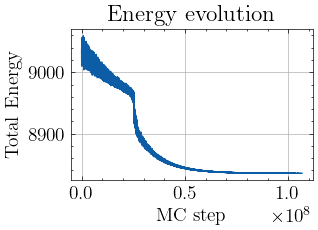

In [69]:

def get_simulation_energy_evolution(simulation_path):
    energy_evolution_file = simulation_path / "energy.out"

    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['mc_step', 'energy', 'temperature', ])
    reset_indices = df['mc_step'].diff() < 0
    offsets = np.where(reset_indices, df['mc_step'].shift(1), 0)
    cumulative_offset = offsets.cumsum()
    df['total_mc_step'] = df['mc_step'] + cumulative_offset

    plt.figure()
    plt.plot(df['total_mc_step'], df['energy'], label='Energía del sistema')
    plt.xlabel('MC step')
    plt.ylabel('Total Energy')
    plt.title('Energy evolution')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "energy_vs_mc_steps.pdf")
    plt.show()
    
get_simulation_energy_evolution(simulation_path)

## **Get thermodynamic observables**

In [70]:
def gamma(rho, T):
    a = (3/(4*np.pi*rho))**(1/3)
    return 1/(a*T)

{'Tc': [np.float64(0.1128278142264741)], 'gamma': [np.float64(14.287185877595675)], 'cv_max_norm': [np.float64(25.770046952495868)], 'density': [1.0], 'simulation': [PosixPath('output/n216_density1.00_t1.0-0.0001-0.98')]}
Results saved in: output/n216_density1.00_t1.0-0.0001-0.98/simulation_results.csv


<>:5: SyntaxWarning:

invalid escape sequence '\s'

<>:5: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_44653/2653461547.py:5: SyntaxWarning:

invalid escape sequence '\s'



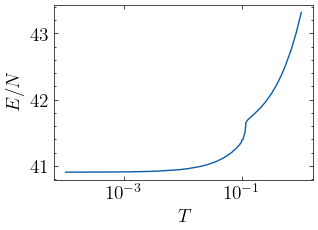

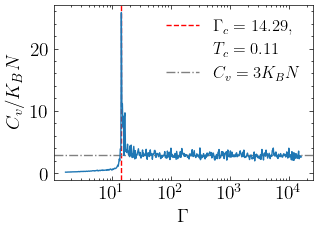

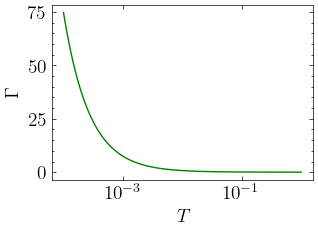

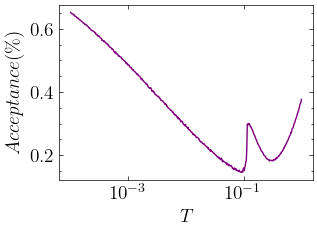

In [71]:
def get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters):
    energy_evolution_file = simulation_path / "heat_capacity.out"
    N = parameters['N']
    density = parameters['density']
    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, names=['temperature', 'energy', 'cv', 'gamma', 'acc_ratio'])

    # Detection of the phase transition
    max_cv = df['cv'].max()
    Tc = df[df['cv'] == max_cv][['temperature', 'gamma']].values
    max_cv = df['cv'].max()
    Tc_val = Tc[0][0]
    gamma_val = Tc[0][1]
    cv_norm = max_cv / N

    results_dict = {
        'Tc': [Tc_val],
        'gamma': [gamma_val],
        'cv_max_norm': [cv_norm],
        'density' : [density],
        'simulation': [simulation_path],
    }

    rho = parameters['density']

    print(results_dict)

    df_results = pd.DataFrame(results_dict)

    output_csv = simulation_path / "simulation_results.csv"
    df_results.to_csv(output_csv, index=False)

    print(f"Results saved in: {output_csv}")

    T = df['temperature']
    # E/N vs. T
    plt.figure()
    plt.plot(T, df['energy']/N + 3/2*T, label=rf'$E/N$')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$E/N$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "energy_per_particle_vs_temperature.pdf")
    plt.show()

    # Cv vs. Gamma
    T = T
    plt.figure(figsize=(3.5, 2.625))
    plt.axvline(gamma_val, linestyle='--', linewidth= 1, color='red', label=rf"$\Gamma_c ={gamma_val:.2f},$")
    plt.plot([], [], ' ', label=rf'$T_c = {Tc_val:.2f}$')

    plt.axhline(3, linestyle='-.', linewidth= 1, color='grey', label = rf"$C_v = 3K_BN$")
    plt.plot(gamma(rho, T), df['cv']/N, color='tab:blue')

    plt.xlabel(r'$\Gamma$')
    plt.ylabel(r' $C_v/K_BN$')
    plt.tight_layout()
    plt.xscale('log')
    plt.legend()
    plt.savefig(simulation_path / "cv_per_particle_vs_gamma_n1.0_N216.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(T, df['gamma']/N, color = 'green', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$\Gamma$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "gamma_vs_temperature.pdf")
    plt.show()

    # Gamma vs. T
    plt.figure()
    plt.plot(T, df['acc_ratio'], color = 'purple', label='Energía del sistema')
    plt.xlabel(r'$T$')
    plt.ylabel(r'$Acceptance (\%)$')
    plt.tight_layout()
    plt.xscale('log')
    plt.savefig(simulation_path / "acc_ratio_vs_temperature.pdf")
    plt.show()

    return df_results

df_results = get_energy_cv_gamma_evolution_vs_temperature(simulation_path, parameters)   

### **Get energy with std**

<>:18: SyntaxWarning:

invalid escape sequence '\s'

<>:18: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_44653/3223433966.py:18: SyntaxWarning:

invalid escape sequence '\s'



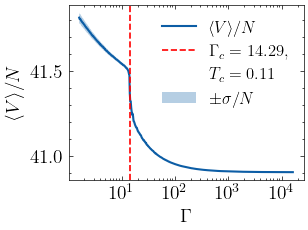

,temperature,avg_energy,std_energy,counts
0,1.000000,9032.001685,6.571415,1633
1,0.980000,9030.206592,6.209658,1633
2,0.960400,9030.265091,6.375322,1633
3,0.941192,9029.765020,6.148300,1633
4,0.922368,9028.266706,6.360256,1633
...,...,...,...,...
452,0.000108,8835.358707,0.002252,1633
453,0.000106,8835.355867,0.002489,1633
454,0.000104,8835.355296,0.002586,1633
455,0.000102,8835.354548,0.002503,1633


In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def gamma(rho, T):
    # Standard OCP definition: Gamma = (Q^2 / a) / (kB * T)
    # where a is the ion-sphere radius: (3 / (4 * pi * rho))^(1/3)
    # Using k_B = 1 and Q = 1 for simplicity, adjust as needed.
    a = (3.0 / (4.0 * np.pi * rho))**(1.0/3.0)
    return 1.0 / (a * T)

def get_detailed_energy_stats(simulation_path, df_results, parameters, discard_fraction=0.3):
    energy_evolution_file = simulation_path / "energy.out"
    N = parameters['N']
    rho = parameters['density']
    
    # Load the data
    df = pd.read_csv(energy_evolution_file, sep='\s+', header=None, 
                     names=['mc_step', 'energy', 'temperature'])
    
    results = []
    # Loop through each temperature in the annealing schedule
    for temp, group in df.groupby('temperature', sort=False):
        # Discard equilibration phase
        n_steps = len(group)
        data = group.iloc[int(n_steps * discard_fraction):]
        
        avg_e = data['energy'].mean()
        std_e = data['energy'].std()
        
        results.append({
            'temperature': temp,
            'avg_energy': avg_e,
            'std_energy': std_e,
            'counts': len(data)
        })

    stats_df = pd.DataFrame(results)

    plt.figure(figsize=(3.5, 2.625))
    T = stats_df['temperature']
    g = gamma(rho, T)
    E = stats_df['avg_energy'] / N 
    err = stats_df['std_energy'] / N
    
    g_c = df_results['gamma'].values[0]
    T_c = df_results['Tc'].values[0]
    
    plt.plot(g, E, '-', linewidth=1.5, label=r'$\langle V \rangle / N$')
    # plt.axvline(g_c, linestyle='--', linewidth=1, color='red', 
    #             label=rf"$\Gamma_c ={g_c:.2f}$, $\\T_c = {T_c:.2f}$")

    plt.axvline(g_c, linestyle='--', linewidth=1.2, color='red',
            label=rf'$\Gamma_c ={g_c:.2f},$')

    plt.plot([], [], ' ', label=rf'$T_c = {T_c:.2f}$')


    plt.fill_between(g, E - err, E + err, alpha=0.3, label=r'$\pm \sigma / N$')

    plt.xlabel(r'$\Gamma$')
    plt.ylabel(r'$\langle V \rangle/N$')
    plt.xscale('log')
    plt.legend()
    plt.tight_layout()
    plt.savefig(simulation_path / "energy_per_particle_vs_gamma_n1.0_N216.pdf")
    plt.show()

    return stats_df

get_detailed_energy_stats(simulation_path, df_results, parameters, discard_fraction=0.3)

## **Radial distribution function**

Results saved in: output/n216_density1.00_t1.0-0.0001-0.98/gr_peaks_results.csv


<>:3: SyntaxWarning:

invalid escape sequence '\s'

<>:3: SyntaxWarning:

invalid escape sequence '\s'

/tmp/ipykernel_44653/802968291.py:3: SyntaxWarning:

invalid escape sequence '\s'



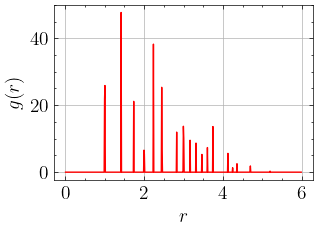

,r,r/a,Acc. Neigh
0,1.005,1.000000,6
1,1.415,1.407960,18
2,1.735,1.726368,26
3,1.995,1.985075,32
4,2.235,2.223881,56
5,2.445,2.432836,80
6,2.825,2.810945,92
7,2.995,2.980100,119
8,3.165,3.149254,131
9,3.315,3.298507,143


In [81]:
def get_gdr(simulation_path, parameters):
    gdr_file = simulation_path / "rdf.out"
    df = pd.read_csv(gdr_file, sep='\s+', header=None, names=['r', 'gr',])
    rho = parameters['density']
    r = df['r'].to_numpy()
    gr = df['gr'].to_numpy()
    dr = r[1]-r[0]
    N = parameters["N"]
    density = parameters["density"]
    a_th = density**(-1/3)
    
    dNc = 4 * np.pi * (r**2) * rho * gr * dr
    Nc = np.cumsum(dNc)

    peak_idx, _ = find_peaks(gr, height=5.0)

    results = []
    for i, idx in enumerate(peak_idx):
        if i == 0:
            a = r[idx]
        distance_r = r[idx]
        idx_end_peak = min(idx + 2, len(r) - 1) 
        acc_neigh = Nc[idx_end_peak]
        results.append({
            'r' : distance_r,
            'r/a' : distance_r/a,
            'Acc. Neigh' : round(acc_neigh)
        })

    df_results = pd.DataFrame(results)
    output_csv = simulation_path / "gr_peaks_results.csv"

    if not os.path.isfile(output_csv):
        df_results.to_csv(output_csv, index=False)
    else:
        df_results.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"Results saved in: {output_csv}")

    # Plot 
    plt.figure()
    plt.plot(df['r'], df['gr'], color = 'red', label='Energía del sistema')
    plt.xlabel(r'$r$')
    plt.ylabel(r'$g(r)$')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "gdr.pdf")
    plt.show()

    return df_results

df_results = get_gdr(simulation_path, parameters)
df_results

## **Structure Factor**

Results saved in: output/n216_density1.00_t1.0-0.0001-0.98/sq_peaks_results.csv


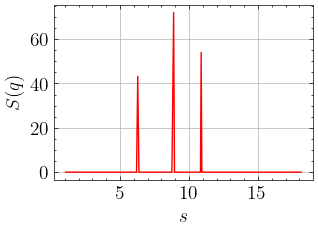

,s,s/a
0,6.2832,1.000000
1,8.8858,1.414216
2,10.8828,1.732047


In [ ]:
def get_sq(simulation_path, parameters):
    sq_file = simulation_path / "sq.csv"
    df = pd.read_csv(sq_file, header=0, names=['s', 'S(q)'])
    rho = parameters['density']
    s = df['s'].to_numpy()
    sq = df['S(q)'].to_numpy()
    N = parameters["N"]
    density = parameters["density"]
    a_th = density**(-1/3)
    
    peak_idx, _ = find_peaks(sq, height=5.0)

    results = []
    for i, idx in enumerate(peak_idx):
        if i == 0:
            a = s[idx]
        distance_r = s[idx]
        results.append({
            's' : distance_r,
            's/a' : distance_r/a,
        })

    df_results = pd.DataFrame(results)
    output_csv = simulation_path / "sq_peaks_results.csv"

    if not os.path.isfile(output_csv):
        df_results.to_csv(output_csv, index=False)
    else:
        df_results.to_csv(output_csv, mode='a', header=False, index=False)

    print(f"Results saved in: {output_csv}")

    # Plot 
    plt.figure()
    plt.plot(df['s'], df['S(q)'], color = 'red', label='Energía del sistema')
    plt.xlabel(r'$s$')
    plt.ylabel(r'$S(q)$')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(simulation_path / "sq.pdf")
    plt.show()

    return df_results

df_results = get_sq(simulation_path, parameters)
df_results

## **Positions plot**

In [ ]:
def get_positions_plot(filename, saved_filename):

    with open(filename, 'r') as f:
        lines = f.readlines()
    
    num_atoms = int(lines[0])
    block_size = num_atoms + 2
    total_frames = len(lines) // block_size
    
    all_data = []
    for f in range(total_frames):
        start = f * block_size + 2
        end = start + num_atoms
        frame_coords = [l.split()[1:4] for l in lines[start:end]]
        
        df_frame = pd.DataFrame(frame_coords, columns=['x', 'y', 'z'], dtype=float)
        df_frame['frame'] = f  
        all_data.append(df_frame)

    df = pd.concat(all_data, ignore_index=True)

    last_frame = df[df['frame'] == df['frame'].max()]

    fig = px.scatter_3d(
        last_frame,
        x='x', y='y', z='z',
        opacity=1.0,
        template="plotly_white"
    )

    fig.update_traces(
        marker=dict(
            size=7,
            color='red',
            line=dict(width=0.5, color='black')
        )
    )

    # Box edges 
    xmin, ymin, zmin = last_frame[['x','y','z']].min()
    xmax, ymax, zmax = last_frame[['x','y','z']].max()

    edges = [
        ([xmin,xmax],[ymin,ymin],[zmin,zmin]),
        ([xmin,xmax],[ymax,ymax],[zmin,zmin]),
        ([xmin,xmax],[ymin,ymin],[zmax,zmax]),
        ([xmin,xmax],[ymax,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymax],[zmin,zmin]),
        ([xmax,xmax],[ymin,ymax],[zmin,zmin]),
        ([xmin,xmin],[ymin,ymax],[zmax,zmax]),
        ([xmax,xmax],[ymin,ymax],[zmax,zmax]),

        ([xmin,xmin],[ymin,ymin],[zmin,zmax]),
        ([xmax,xmax],[ymin,ymin],[zmin,zmax]),
        ([xmin,xmin],[ymax,ymax],[zmin,zmax]),
        ([xmax,xmax],[ymax,ymax],[zmin,zmax])
    ]

    for ex, ey, ez in edges:
        fig.add_scatter3d(x=ex, y=ey, z=ez, mode='lines',
                        line=dict(color='black', width=4),
                        showlegend=False)

    fig.update_layout(
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, title='x'),
            yaxis=dict(showbackground=False, title='y'),
            zaxis=dict(showbackground=False, title='z'),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1.6, y=1.6, z=1.3)
            )
        ),
        title_x=0.5
    )

    # Positions array
    pos = last_frame[['x','y','z']].values

    # Bonds
    tree = cKDTree(pos)
    dists, _ = tree.query(pos, k=7)  
    a = np.median(dists[:,1])        
    pairs = tree.query_pairs(r=1.2*a)

    for i, j in pairs:
        fig.add_scatter3d(
            x=[pos[i,0], pos[j,0]],
            y=[pos[i,1], pos[j,1]],
            z=[pos[i,2], pos[j,2]],
            mode='lines',
            line=dict(color='black', width=1),
            opacity=0.5,
            showlegend=False
        )

    fig.update_layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene=dict(
            aspectmode='cube',
            xaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            yaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            zaxis=dict(showbackground=False, showticklabels=False, showgrid=False, zeroline=False, title=''),
            camera=dict(
                projection=dict(type="orthographic"),
                eye=dict(x=1, y=1, z=1)
            ),
            
        )
    )

    fig.show()
    fig.write_html(f"{saved_filename}.html")
    fig.write_image(f"{saved_filename}.pdf", scale=3, width=250, height=300)

    return 

filename = simulation_path / "final_position.xyz"
saved_filename = simulation_path / "positions"
get_positions_plot(filename, saved_filename)